In [2]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
#from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [4]:
EPOCHS =50
INIT_LR = 3e-3
BS =32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"D:\DP\Historical Building Cracks"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
train_image_list, train_image_label=[],[]
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing crack ...
processing non-crack ...
[INFO] Image loading completed


In [7]:
print(len(train_image_label))

3892


In [8]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_crack_labe16.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [9]:
print(len(bin_train_image_labels))

3892


In [10]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [12]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 224
img_width = 224
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):#3
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):#4
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):#6
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):#3
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 256 19456       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 256 1024        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 112, 112, 256 0           batch_normalization[0][0]        
______________________________________________________________________________________________

lambda_394 (Lambda)             (None, 14, 14, 8)    0           leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
lambda_395 (Lambda)             (None, 14, 14, 8)    0           leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
lambda_396 (Lambda)             (None, 14, 14, 8)    0           leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
lambda_397 (Lambda)             (None, 14, 14, 8)    0           leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
lambda_398 (Lambda)             (None, 14, 14, 8)    0           leaky_re_lu_37[0][0]             
__________________________________________________________________________________________________
lambda_399

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [15]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(y_val,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 3113 samples, validate on 779 samples
Epoch 1/50
3113/3113 [==============================] - 91s 29ms/sample - loss: 1.1892 - accuracy: 0.8040 - val_loss: 3.1168 - val_accuracy: 0.7985
Epoch 2/50
3113/3113 [==============================] - 43s 14ms/sample - loss: 0.3344 - accuracy: 0.9027 - val_loss: 1.2670 - val_accuracy: 0.7997
Epoch 3/50
3113/3113 [==============================] - 44s 14ms/sample - loss: 0.2507 - accuracy: 0.9303 - val_loss: 0.7365 - val_accuracy: 0.8151
Epoch 4/50
3113/3113 [==============================] - 44s 14ms/sample - loss: 0.2386 - accuracy: 0.9280 - val_loss: 0.3930 - val_accuracy: 0.8626
Epoch 5/50
3113/3113 [==============================] - 43s 14ms/sample - loss: 0.1919 - accuracy: 0.9383 - val_loss: 0.2855 - val_accuracy: 0.8935
Epoch 6/50
3113/3113 [==============================] - 44s 14ms/sample - loss: 0.1948 - accuracy: 0.9412 - val_loss: 0.3739 - val_accuracy: 0.9191
Epoch 7/50
3113/3113 [==============================] - 43s 14ms/

3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0633 - accuracy: 0.9762 - val_loss: 0.1704 - val_accuracy: 0.9576
Epoch 6/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0825 - accuracy: 0.9685 - val_loss: 0.2213 - val_accuracy: 0.9371
Epoch 7/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0508 - accuracy: 0.9823 - val_loss: 0.1460 - val_accuracy: 0.9564
Epoch 8/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0912 - accuracy: 0.9704 - val_loss: 0.1478 - val_accuracy: 0.9422
Epoch 9/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.2369 - val_accuracy: 0.9422
Epoch 10/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0454 - accuracy: 0.9830 - val_loss: 0.1394 - val_accuracy: 0.9564
Epoch 11/50
3113/3113 [==============================] - 42s 14ms/sample - loss: 0.0570 - accuracy: 0.9801 - val_loss: 0.1

Epoch 10/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0070 - accuracy: 0.9971 - val_loss: 0.0998 - val_accuracy: 0.9846
Epoch 11/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0114 - val_accuracy: 0.9961
Epoch 12/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0552 - val_accuracy: 0.9884
Epoch 13/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0282 - accuracy: 0.9900 - val_loss: 0.3935 - val_accuracy: 0.9280
Epoch 14/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0703 - accuracy: 0.9801 - val_loss: 0.0812 - val_accuracy: 0.9704
Epoch 15/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0224 - val_accuracy: 0.9910
Epoch 16/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0025 - accuracy: 0.9997

3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.0048 - val_accuracy: 0.9987
Epoch 15/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 16/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0041 - accuracy: 0.9987 - val_loss: 9.0774e-04 - val_accuracy: 1.0000
Epoch 17/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 18/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 2.7881e-04 - accuracy: 1.0000 - val_loss: 9.5139e-04 - val_accuracy: 1.0000
Epoch 19/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 4.0408e-04 - accuracy: 1.0000 - val_loss: 2.5241e-04 - val_accuracy: 1.0000
Epoch 20/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 3.7055e-04 - accu

3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.1570 - val_accuracy: 0.9820
Epoch 19/50
3114/3114 [==============================] - 44s 14ms/sample - loss: 0.0015 - accuracy: 0.9990 - val_loss: 0.0258 - val_accuracy: 0.9923
Epoch 20/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0985 - val_accuracy: 0.9666
Epoch 21/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0959 - val_accuracy: 0.9871
Epoch 22/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0335 - val_accuracy: 0.9884
Epoch 23/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0112 - val_accuracy: 0.9961
Epoch 24/50
3114/3114 [==============================] - 43s 14ms/sample - loss: 0.0185 - accuracy: 0.9961 - val_loss:

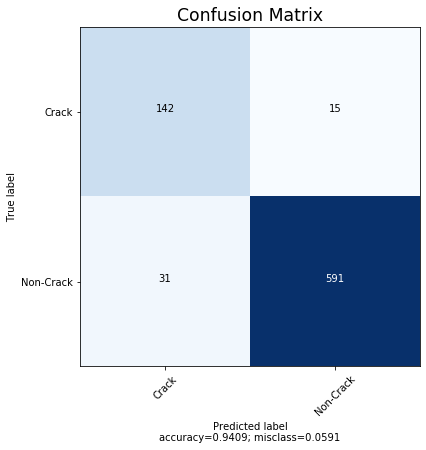

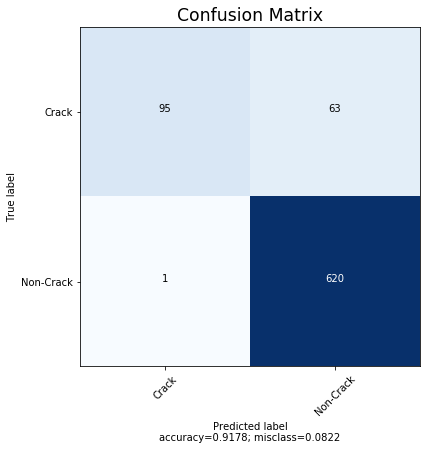

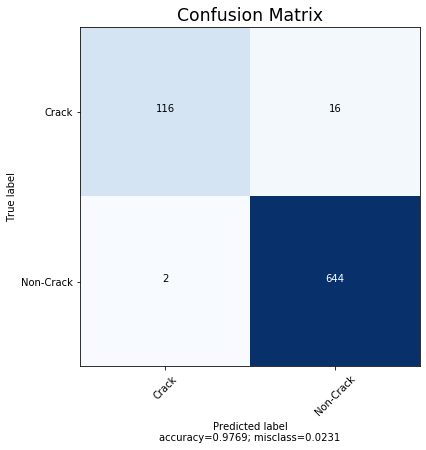

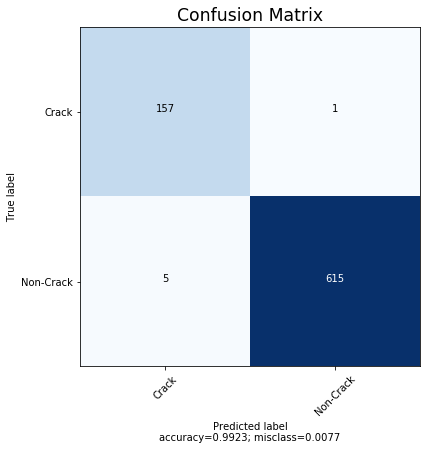

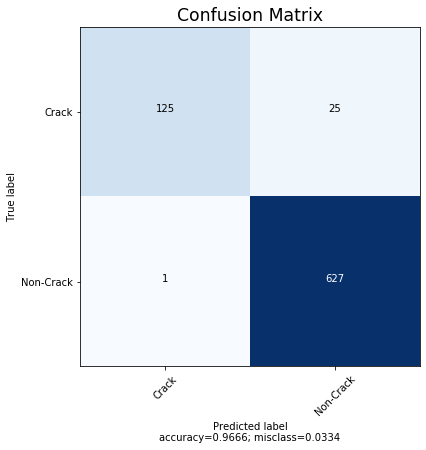

In [16]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['Crack', 'Non-Crack'],
                      title        = "Confusion Matrix")

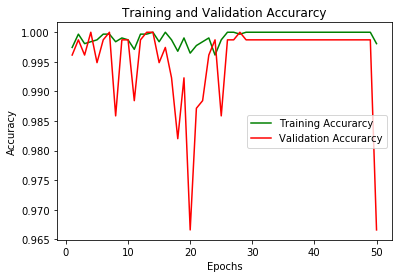

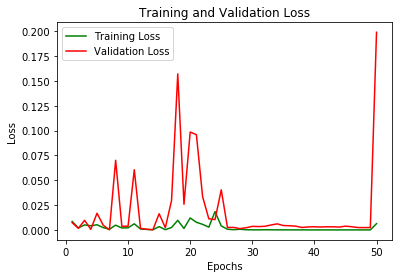

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

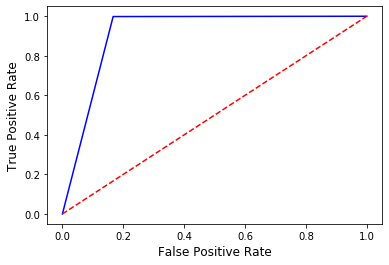

In [18]:
fpr, tpr, threshold = roc_curve(y_val,yhat_classes) 

plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.show()